# Data Integrity
In this notebook, we examine the customer and transaction datasets to ensure they are fit for purpose. We want to identify where there may be outliers, nonsensical or missing values in each variable and check distributions etc look as we'd expect them too. 

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data read
cust  = pd.read_csv('banking_churn_data/customers_tm1_e.csv')
trans = pd.read_csv('banking_churn_data/transactions_tm1_e.csv')

## Customers dataset

In [41]:
print('Number of observations: ', cust.shape)
cust.head()

Number of observations:  (116016, 5)


customer_id         dob       state  start_balance creation_date
0           91  1993-07-01  California       10180.56    2007-01-31
1           92  1985-12-05    New York        4757.68    2007-01-31
2           93  1987-11-19   Minnesota        6796.72    2007-01-31
3           94  1981-03-23   Minnesota        9870.48    2007-01-31
4           95  1970-04-06  California       12500.72    2007-01-31

#### Missing Values
We have only 3 missing values for start_balance.

In [42]:
cust.isnull().sum(axis=0)

customer_id      0
dob              0
state            0
start_balance    3
creation_date    0
dtype: int64

In [43]:
cust[cust['start_balance'].isnull()]
print('Null balance customer ids', list(cust[cust['start_balance'].isnull()].customer_id))
# we remove these further down the notebook

Null balance customer ids [21334, 45982, 96030]


#### Customer id variable
We see below that the customer id iterates through numbers 91 to 116106. Each customer has a unique id.

In [44]:
#customer_id variable
cust['customer_id'].describe() # we see this makes sense

count    116016.000000
mean      58098.500000
std       33491.078752
min          91.000000
25%       29094.750000
50%       58098.500000
75%       87102.250000
max      116106.000000
Name: customer_id, dtype: float64

#### Date of birth
The distribution below makes sense, showing that a majority of customers are millenials/middle-aged, with fewer older or younger customers.

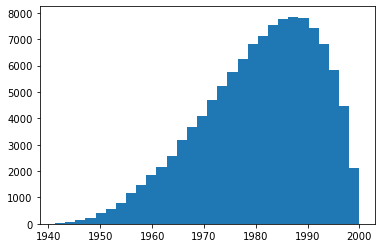

In [45]:
cust['dob'] = pd.to_datetime(cust['dob'])
cust['dob'] = cust['dob'].dt.date
fig, ax = plt.subplots()
ax.hist(cust['dob'], bins=30);

#### State

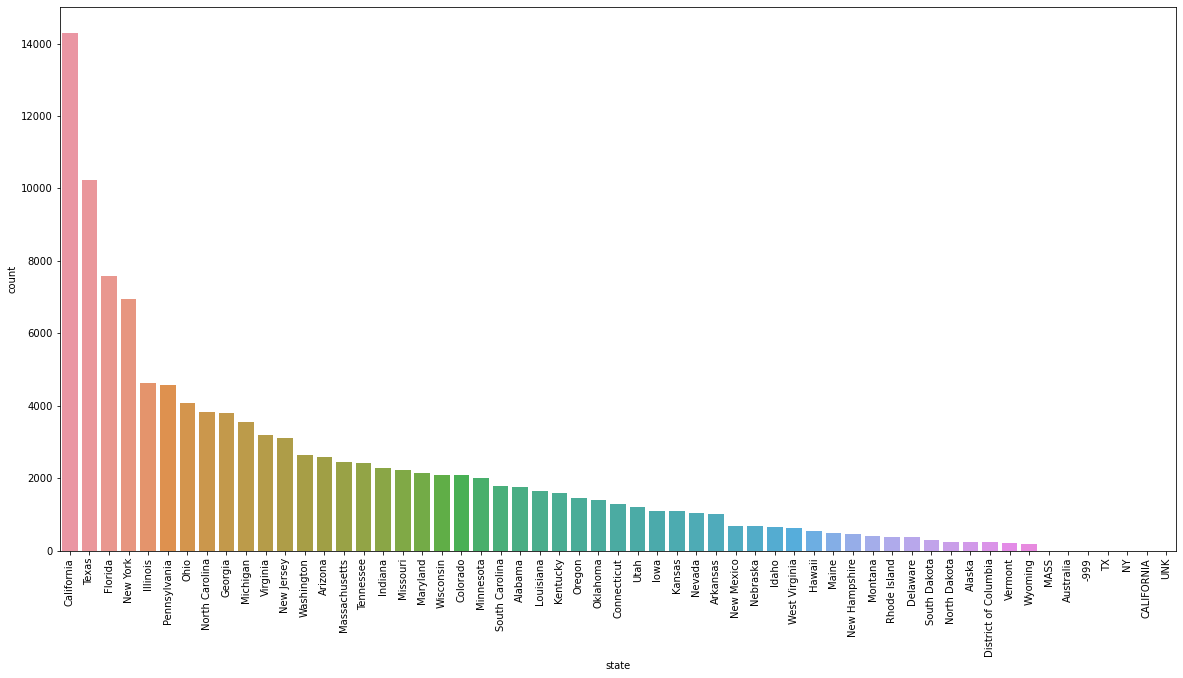

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(data = cust, x = 'state', ax=ax, order = cust['state'].value_counts().index)
ax.xaxis.set_tick_params(rotation=90)

At a glance, the distribution of customers across states look broadly in line with state populations. There are some inconsistencies which we correct below.  
We may later remove the unknowns.

In [47]:
cust['state'] = cust['state'].apply(lambda x: 'New York' if x=='NY' else x)
cust['state'] = cust['state'].apply(lambda x: 'Texas' if x=='TX' else x)
cust['state'] = cust['state'].apply(lambda x: 'California' if x=='CALIFORNIA' else x)
cust['state'] = cust['state'].apply(lambda x: 'Massachusetts' if x=='MASS' else x)
cust['state'] = cust['state'].apply(lambda x: 'UNK' if x in ['Australia', '-999'] else x)

In [48]:
print(cust[cust['state']=='UNK'].shape) # we drop these
print(list(cust[cust['state']=='UNK'].customer_id.unique()))
cust=cust[cust['state']!='UNK'].reset_index(drop=True)

(9, 5)
[7012, 7968, 37710, 38895, 67790, 70699, 82548, 93096, 104611]


#### Start Balance

In [49]:
cust['start_balance'].describe()

count    1.160040e+05
mean    -5.381881e+04
std      3.008565e+07
min     -1.000000e+10
25%      3.157570e+03
50%      6.297240e+03
75%      9.511180e+03
max      2.000000e+09
Name: start_balance, dtype: float64

In [50]:
print('Negative starting balances: ', cust[cust['start_balance']<0].shape[0])
print('Negative starting balances cust_ids', list(cust[cust['start_balance']<0].customer_id))
print('High starting balances: ', cust[cust['start_balance']>1e6].shape[0])
print('High starting balances cust_ids', list(cust[cust['start_balance']>1e6].customer_id))

Negative starting balances:  1
Negative starting balances cust_ids [42704]
High starting balances:  2
High starting balances cust_ids [43658, 68359]


As our savings accounts are aimed at middle class, it is safe to assume these high values are errors or are very much not representative of the population. As such we remove them.

In [51]:
cust = cust[(cust['start_balance']>=0) & (cust['start_balance']<=1e6)].reset_index(drop=True)

In [52]:
print(cust[cust['start_balance']==0].shape[0]) # not unreasonable to assume this is possible
cust['start_balance'].describe()

1


count    116001.000000
mean       6524.103108
std        4016.720052
min           0.000000
25%        3157.600000
50%        6297.240000
75%        9511.040000
max       30058.760000
Name: start_balance, dtype: float64

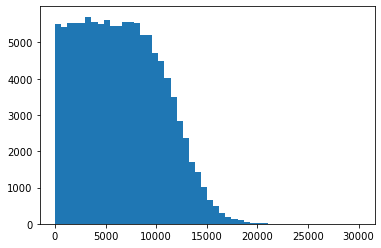

In [53]:
fig, ax = plt.subplots()
ax.hist(cust.start_balance, bins=50);

The distribution of starting balance seems to be surprisingly uniform up to 10000, then descends quite quickly beyond. 
The range makes sense based on the target audience of the product. However the shape is somewhat surprising and may be worth investigating further.

#### Creation date

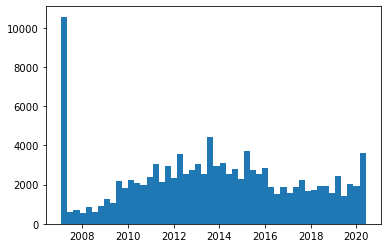

In [54]:
cust['creation_date'] = pd.to_datetime(cust['creation_date'])
cust['creation_date'] = cust['creation_date'].dt.date
fig, ax = plt.subplots()
ax.hist(cust['creation_date'], bins=50);

Large number of accounts at start of period is due to a migration of active accounts on old product to this savings product. 

## Transactions dataset
Contains list of customer deposits and withdrawals and balance checks ordered by month (end of month) and customer id. 

In [55]:
print('Number of observations: ', trans.shape)
trans.head()

Number of observations:  (4977972, 7)


date  account_id  customer_id   amount transaction_date  deposit  \
0  2007-01-31    24137947           91  3034.26       2007-01-31  3034.26   
1  2007-01-31    24137947           91 -5295.18       2007-01-16     0.00   
2  2007-02-28    24137947           91     0.00       2007-02-28     0.00   
3  2007-03-31    24137947           91    -0.00       2007-03-30     0.00   
4  2007-03-31    24137947           91    -0.00       2007-03-11     0.00   

   withdrawal  
0        0.00  
1    -5295.18  
2        0.00  
3       -0.00  
4       -0.00

#### Missing values
No missing values!

In [56]:
trans.isnull().sum(axis=0)

date                0
account_id          0
customer_id         0
amount              0
transaction_date    0
deposit             0
withdrawal          0
dtype: int64

#### Account id and customer_id
We see a one-to-one relationship between customer id and account_id. So the account_id column is likely redundant.  
We also see that the customer_ids line up with those in the customer data, with the transaction data containing all of them. 

In [57]:
#drop deleted customer_ids
dropped_ids = [42704, 43658, 68359, 21334, 45982, 96030, 7012, 7968, 37710, 38895, 67790, 70699, 82548, 93096, 104611]
trans = trans[~trans['customer_id'].isin(dropped_ids)].reset_index(drop=True)

In [58]:
print('Number of customers:', len(trans.customer_id.unique()))
print('Number of accounts:', len(trans.account_id.unique()))
print(np.array_equal(np.sort(trans.customer_id.unique()) , cust.customer_id.unique()))

Number of customers: 116001
Number of accounts: 116001
True


In [59]:
#drop account_id column
trans.drop('account_id', axis=1, inplace=True)

In [60]:
trans.head()

date  customer_id   amount transaction_date  deposit  withdrawal
0  2007-01-31           91  3034.26       2007-01-31  3034.26        0.00
1  2007-01-31           91 -5295.18       2007-01-16     0.00    -5295.18
2  2007-02-28           91     0.00       2007-02-28     0.00        0.00
3  2007-03-31           91    -0.00       2007-03-30     0.00       -0.00
4  2007-03-31           91    -0.00       2007-03-11     0.00       -0.00

#### Date
This is basically an index column. But below we look at the distribution.  
Might change this to a line plot through time.  
It is interesting that the number of transactions seems to increase through time. Could be due to the portfolio getting larger - will explore more during EDA phase

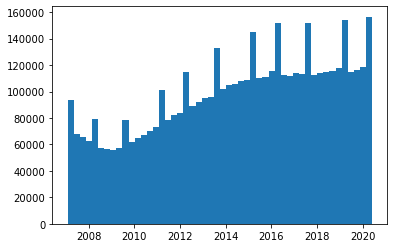

In [61]:
trans['date'] = pd.to_datetime(trans['date'])
trans['date'] = trans['date'].dt.date
fig, ax = plt.subplots()
ax.hist(trans['date'], bins=50);

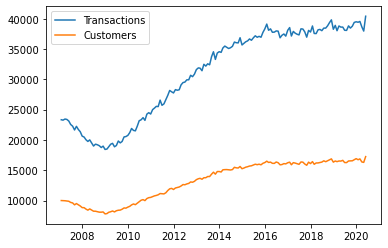

In [62]:
#plotting number of transactions vs size of portfolio
trans.groupby('date').customer_id.nunique()
fig, ax = plt.subplots()
ax.plot(trans.groupby('date')['customer_id'].count(), label='Transactions') #all observations for each date (i.e. number trans)
ax.plot(trans.groupby('date')['customer_id'].nunique(), label='Customers') #unique customers on that date
ax.legend(loc='best')
#fix axis later

#### Transaction date
This is likely a redundant column if we aggregate by month, so we don't explore it. 

#### Deposit, Withdrawal and Amount
We see below that there are some extreme values for amount.

In [63]:
trans[['deposit', 'withdrawal', 'amount']].describe()

deposit    withdrawal        amount
count  4.977220e+06  4.977220e+06  4.977220e+06
mean   6.683890e+02 -6.399257e+02 -1.794542e+04
std    1.155287e+03  1.206431e+03  1.526813e+07
min    0.000000e+00 -1.678565e+04 -1.000000e+10
25%    0.000000e+00 -7.501600e+02 -7.501700e+02
50%    0.000000e+00 -2.631000e+01 -2.631000e+01
75%    1.042090e+03  0.000000e+00  1.042090e+03
max    9.888510e+03  0.000000e+00  2.934292e+09

In [64]:
#remove these
trans = trans[(trans['amount']>-1e9) & (trans['amount']<1e9)].reset_index(drop=True)
trans[['deposit', 'withdrawal', 'amount']].describe()

deposit    withdrawal        amount
count  4.977202e+06  4.977202e+06  4.977202e+06
mean   6.683902e+02 -6.399270e+02  2.846319e+01
std    1.155288e+03  1.206433e+03  1.909349e+03
min    0.000000e+00 -1.678565e+04 -1.678565e+04
25%    0.000000e+00 -7.501600e+02 -7.501600e+02
50%    0.000000e+00 -2.630000e+01 -2.630000e+01
75%    1.042090e+03  0.000000e+00  1.042090e+03
max    9.888510e+03  0.000000e+00  9.888510e+03

We check whether a transaction can be both deposit and withdrawal.

In [65]:
print('Number of transactions:', trans.shape[0])
temp = trans[trans['deposit']!=0].shape[0] + trans[trans['withdrawal']!=0].shape[0] \
+ trans[(trans['deposit']==0) & (trans['withdrawal']==0)].shape[0]
print('Number of expected behaviour transactions:', temp)

Number of transactions: 4977202
Number of expected behaviour transactions: 4977202


Great! We now check whether deposit + withdrawal = amount

In [66]:
print('Number not equal:', trans[trans['amount']!=trans['deposit']+trans['withdrawal']].shape[0])

Number not equal: 0


## Saving datasets

In [67]:
cust.head()

customer_id         dob       state  start_balance creation_date
0           91  1993-07-01  California       10180.56    2007-01-31
1           92  1985-12-05    New York        4757.68    2007-01-31
2           93  1987-11-19   Minnesota        6796.72    2007-01-31
3           94  1981-03-23   Minnesota        9870.48    2007-01-31
4           95  1970-04-06  California       12500.72    2007-01-31

In [68]:
trans.head()

date  customer_id   amount transaction_date  deposit  withdrawal
0  2007-01-31           91  3034.26       2007-01-31  3034.26        0.00
1  2007-01-31           91 -5295.18       2007-01-16     0.00    -5295.18
2  2007-02-28           91     0.00       2007-02-28     0.00        0.00
3  2007-03-31           91    -0.00       2007-03-30     0.00       -0.00
4  2007-03-31           91    -0.00       2007-03-11     0.00       -0.00

In [69]:
cust.to_csv('churn_project/banking_churn_data/customers_clean.csv', index=False)
trans.to_csv('churn_project/banking_churn_data/transactions_clean.csv', index=False)

## ---------------------------------------------------------------------------

### Miscellaneous bits below to remove

In [56]:
#len(cust.customer_id.unique())

Empty DataFrame
Columns: [index, date, account_id, customer_id, amount, transaction_date, deposit, withdrawal]
Index: []

In [156]:
cust.sort_values('start_balance',ascending=False)
#some NAN starting balances (95939,45891,21243) and 0 starting balance at 37823

customer_id         dob                 state  start_balance  \
60550        60645  1989-06-17  District of Columbia       30058.76   
51089        51184  1985-02-11  District of Columbia       27944.16   
47429        47524  1984-06-13  District of Columbia       26659.32   
21601        21693  1974-06-28  District of Columbia       25503.12   
11873        11964  1996-07-13  District of Columbia       25424.88   
...            ...         ...                   ...            ...   
70828        70924  1983-06-18               Arizona           0.48   
92390        92486  1977-08-26            Washington           0.44   
55893        55988  1980-06-03        South Carolina           0.08   
96715        96812  1989-04-07               Indiana           0.04   
37822        37914  1978-07-10        North Carolina           0.00   

      creation_date  
60550    2013-11-30  
51089    2013-01-31  
47429    2012-10-31  
21601    2010-01-31  
11873    2007-10-31  
...             ...  
70828    2014-10-31  
92390    2017-03-31  
55893    2013-07-31  
96715    2017-11-30  
37822    2011-10-31  

[116010 rows x 5 columns]

In [157]:
cust[cust.start_balance < 10].sort_values('start_balance')

customer_id         dob           state  start_balance creation_date
37822        37914  1978-07-10  North Carolina           0.00    2011-10-31
96715        96812  1989-04-07         Indiana           0.04    2017-11-30
55893        55988  1980-06-03  South Carolina           0.08    2013-07-31
92390        92486  1977-08-26      Washington           0.44    2017-03-31
70828        70924  1983-06-18         Arizona           0.48    2014-10-31
...            ...         ...             ...            ...           ...
35780        35872  1995-03-25        New York           9.16    2011-08-31
94233        94329  1981-01-12     Connecticut           9.20    2017-07-31
43321        43414  1974-03-16            Ohio           9.20    2012-05-31
95119        95215  1971-09-22           Texas           9.68    2017-08-31
28947        29039  1995-09-30           Texas           9.96    2010-11-30

[88 rows x 5 columns]

### Transactions dataset

In [50]:
cust.head(20)

customer_id         dob          state  start_balance creation_date
0            91  1993-07-01     California       10180.56    2007-01-31
1            92  1985-12-05       New York        4757.68    2007-01-31
2            93  1987-11-19      Minnesota        6796.72    2007-01-31
3            94  1981-03-23      Minnesota        9870.48    2007-01-31
4            95  1970-04-06     California       12500.72    2007-01-31
5            96  1968-12-13     California       11663.00    2007-01-31
6            97  1967-12-18       Colorado       14818.28    2007-01-31
7            98  1974-06-06       Kentucky       10348.52    2007-01-31
8            99  1973-11-29       Virginia       14167.96    2007-01-31
9           100  1981-10-21      Tennessee        4669.80    2007-01-31
10          101  1971-10-17       Illinois        3552.28    2007-01-31
11          102  1981-12-24        Florida        8718.24    2007-01-31
12          103  1981-12-02  Massachusetts        3859.96    2007-01-31
13          104  1995-03-06        Alabama        9305.64    2007-01-31
14          105  1988-08-24        Indiana        5941.44    2007-01-31
15          106  1951-09-22       Illinois        7387.88    2007-01-31
16          107  1995-06-22       New York       11445.04    2007-01-31
17          108  1992-04-02         Kansas        3313.68    2007-01-31
18          109  1988-10-21   Pennsylvania        8716.40    2007-01-31
19          110  1981-11-07      Wisconsin         863.00    2007-01-31

In [31]:
# target by aggregating and finding where withdrawing all?
print(trans.shape)
trans.head(20)

(4977972, 7)


date  account_id  customer_id   amount transaction_date  deposit  \
0   2007-01-31    24137947           91  3034.26       2007-01-31  3034.26   
1   2007-01-31    24137947           91 -5295.18       2007-01-16     0.00   
2   2007-02-28    24137947           91     0.00       2007-02-28     0.00   
3   2007-03-31    24137947           91    -0.00       2007-03-30     0.00   
4   2007-03-31    24137947           91    -0.00       2007-03-11     0.00   
5   2007-03-31    24137947           91    -0.00       2007-03-20     0.00   
6   2007-01-31    24137948           92     0.00       2007-01-31     0.00   
7   2007-02-28    24137948           92  1164.90       2007-02-28  1164.90   
8   2007-03-31    24137948           92  1257.38       2007-03-31  1257.38   
9   2007-04-30    24137948           92  1338.12       2007-04-30  1338.12   
10  2007-05-31    24137948           92  1393.85       2007-05-31  1393.85   
11  2007-05-31    24137948           92 -1556.51       2007-05-14     0.00   
12  2007-05-31    24137948           92  -548.83       2007-05-24     0.00   
13  2007-06-30    24137948           92     0.00       2007-06-30     0.00   
14  2007-07-31    24137948           92  1494.26       2007-07-31  1494.26   
15  2007-08-31    24137948           92  1345.73       2007-08-31  1345.73   
16  2007-08-31    24137948           92  -319.79       2007-08-06     0.00   
17  2007-08-31    24137948           92  -104.97       2007-08-23     0.00   
18  2007-08-31    24137948           92  -276.08       2007-08-05     0.00   
19  2007-08-31    24137948           92   -80.87       2007-08-15     0.00   

    withdrawal  
0         0.00  
1     -5295.18  
2         0.00  
3        -0.00  
4        -0.00  
5        -0.00  
6         0.00  
7         0.00  
8         0.00  
9         0.00  
10        0.00  
11    -1556.51  
12     -548.83  
13        0.00  
14        0.00  
15        0.00  
16     -319.79  
17     -104.97  
18     -276.08  
19      -80.87

In [62]:
trans['sum'] = trans['deposit']+trans['withdrawal']
trans[trans['amount']!=trans['sum']]


date  account_id  customer_id        amount transaction_date  \
556196   2007-08-31    24147678         9822 -1.000000e+10       2007-08-31   
556197   2007-08-31    24147678         9822 -1.000000e+10       2007-08-12   
556198   2007-08-31    24147678         9822 -1.000000e+10       2007-08-27   
556199   2007-08-31    24147678         9822 -1.000000e+10       2007-08-29   
556200   2007-08-31    24147678         9822 -1.000000e+10       2007-08-10   
556201   2007-08-31    24147678         9822 -1.000000e+10       2007-08-17   
556202   2007-08-31    24147678         9822 -1.000000e+10       2007-08-12   
1419211  2011-10-31    24168297        30441 -1.000000e+10       2011-10-31   
1419212  2011-10-31    24168297        30441 -1.000000e+10       2011-10-24   
1419213  2011-10-31    24168297        30441 -1.000000e+10       2011-10-04   
1419214  2011-10-31    24168297        30441 -1.000000e+10       2011-10-20   
3491873  2018-07-31    24215541        77685  2.934292e+09       2018-07-31   
3491874  2018-07-31    24215541        77685  2.934292e+09       2018-07-15   
3491875  2018-07-31    24215541        77685  2.934292e+09       2018-07-28   
3491876  2018-07-31    24215541        77685  2.934292e+09       2018-07-31   
3491877  2018-07-31    24215541        77685  2.934292e+09       2018-07-31   
3491878  2018-07-31    24215541        77685  2.934292e+09       2018-07-02   
3743186  2019-05-31    24220127        82271  2.934292e+09       2019-05-31   

         deposit  withdrawal      sum  
556196   1703.45        0.00  1703.45  
556197      0.00      -73.91   -73.91  
556198      0.00     -898.84  -898.84  
556199      0.00     -102.68  -102.68  
556200      0.00     -291.17  -291.17  
556201      0.00     -463.53  -463.53  
556202      0.00     -749.91  -749.91  
1419211  1577.41        0.00  1577.41  
1419212     0.00    -1005.71 -1005.71  
1419213     0.00     -685.87  -685.87  
1419214     0.00     -250.35  -250.35  
3491873   214.95        0.00   214.95  
3491874     0.00      -13.76   -13.76  
3491875     0.00     -145.06  -145.06  
3491876     0.00     -185.35  -185.35  
3491877     0.00     -111.30  -111.30  
3491878     0.00      -10.92   -10.92  
3743186  2579.60        0.00  2579.60

In [54]:
trans_cust = trans['customer_id'].unique()
cust_cust  = cust['customer_id'].unique()
print('Number of customers in customer dataset:', len(cust_cust))
np.array_equal(trans_cust, cust_cust)

Number of customers in customer dataset: 116016


True

In [55]:
trans[trans['customer_id']==91]

date  account_id  customer_id   amount transaction_date  deposit  \
0  2007-01-31    24137947           91  3034.26       2007-01-31  3034.26   
1  2007-01-31    24137947           91 -5295.18       2007-01-16     0.00   
2  2007-02-28    24137947           91     0.00       2007-02-28     0.00   
3  2007-03-31    24137947           91    -0.00       2007-03-30     0.00   
4  2007-03-31    24137947           91    -0.00       2007-03-11     0.00   
5  2007-03-31    24137947           91    -0.00       2007-03-20     0.00   

   withdrawal      sum  
0        0.00  3034.26  
1    -5295.18 -5295.18  
2        0.00     0.00  
3       -0.00     0.00  
4       -0.00     0.00  
5       -0.00     0.00

In [56]:
trans[trans['customer_id']==92]

date  account_id  customer_id   amount transaction_date  deposit  \
6   2007-01-31    24137948           92     0.00       2007-01-31     0.00   
7   2007-02-28    24137948           92  1164.90       2007-02-28  1164.90   
8   2007-03-31    24137948           92  1257.38       2007-03-31  1257.38   
9   2007-04-30    24137948           92  1338.12       2007-04-30  1338.12   
10  2007-05-31    24137948           92  1393.85       2007-05-31  1393.85   
11  2007-05-31    24137948           92 -1556.51       2007-05-14     0.00   
12  2007-05-31    24137948           92  -548.83       2007-05-24     0.00   
13  2007-06-30    24137948           92     0.00       2007-06-30     0.00   
14  2007-07-31    24137948           92  1494.26       2007-07-31  1494.26   
15  2007-08-31    24137948           92  1345.73       2007-08-31  1345.73   
16  2007-08-31    24137948           92  -319.79       2007-08-06     0.00   
17  2007-08-31    24137948           92  -104.97       2007-08-23     0.00   
18  2007-08-31    24137948           92  -276.08       2007-08-05     0.00   
19  2007-08-31    24137948           92   -80.87       2007-08-15     0.00   
20  2007-08-31    24137948           92  -171.73       2007-08-20     0.00   
21  2007-08-31    24137948           92  -478.39       2007-08-21     0.00   
22  2007-08-31    24137948           92  -475.03       2007-08-23     0.00   
23  2007-08-31    24137948           92   -80.49       2007-08-03     0.00   
24  2007-08-31    24137948           92  -149.49       2007-08-05     0.00   
25  2007-09-30    24137948           92  1277.93       2007-09-30  1277.93   
26  2007-10-31    24137948           92  1265.13       2007-10-31  1265.13   
27  2007-10-31    24137948           92 -1796.54       2007-10-29     0.00   
28  2007-11-30    24137948           92  1336.15       2007-11-30  1336.15   
29  2007-11-30    24137948           92  -223.75       2007-11-22     0.00   
30  2007-11-30    24137948           92  -126.35       2007-11-16     0.00   
31  2007-11-30    24137948           92  -500.74       2007-11-14     0.00   
32  2007-11-30    24137948           92  -739.59       2007-11-03     0.00   
33  2007-12-31    24137948           92  1418.64       2007-12-31  1418.64   
34  2008-01-31    24137948           92     0.00       2008-01-31     0.00   
35  2008-02-29    24137948           92     0.00       2008-02-29     0.00   
36  2008-03-31    24137948           92    -0.00       2008-03-14     0.00   

    withdrawal      sum  
6         0.00     0.00  
7         0.00  1164.90  
8         0.00  1257.38  
9         0.00  1338.12  
10        0.00  1393.85  
11    -1556.51 -1556.51  
12     -548.83  -548.83  
13        0.00     0.00  
14        0.00  1494.26  
15        0.00  1345.73  
16     -319.79  -319.79  
17     -104.97  -104.97  
18     -276.08  -276.08  
19      -80.87   -80.87  
20     -171.73  -171.73  
21     -478.39  -478.39  
22     -475.03  -475.03  
23      -80.49   -80.49  
24     -149.49  -149.49  
25        0.00  1277.93  
26        0.00  1265.13  
27    -1796.54 -1796.54  
28        0.00  1336.15  
29     -223.75  -223.75  
30     -126.35  -126.35  
31     -500.74  -500.74  
32     -739.59  -739.59  
33        0.00  1418.64  
34        0.00     0.00  
35        0.00     0.00  
36       -0.00     0.00

In [ ]:
#cust['dob'] = pd.to_datetime(cust['dob'])
#cust['dob'] = cust['dob'].dt.date
#fig, ax = plt.subplots()
#ax.hist(trans['dob'], bins=30);